In [1]:
import pandas as pd
import numpy as np
import datetime as dt # for date data type
import seaborn as sns # For creating plots
import geopandas as gdp
import matplotlib.pyplot as plt
import plotly.express as px

# Preproccesign and getting a first look at the Data

In [2]:
data = pd.read_csv("Traffic-uus-2.csv")
data

Time  Scheme type nr  \
0      24.10.2014 08:45:00           104.0   
1      24.10.2014 13:45:00           401.0   
2      08.11.2014 15:10:00           207.0   
3      17.11.2014 17:32:00           606.0   
4      28.04.2015 07:55:00           505.0   
...                    ...             ...   
12627  21.05.2017 09:35:00           207.0   
12628  21.05.2017 13:50:00           601.0   
12629  22.05.2017 18:29:00           203.0   
12630  22.05.2017 20:02:00           401.0   
12631  16.04.2018 16:20:00           502.0   

                                         Scheme type_1  \
0                     Vehicle conflict with pedestrian   
1      Vehicles moving to same direction (not passing)   
2                              Single vehicle accident   
3                    Vehicles from opposite directions   
4                    Vehicles from crossing directions   
...                                                ...   
12627                          Single vehicle accident   
12628                Vehicles from opposite directions   
12629                          Single vehicle accident   
12630  Vehicles moving to same direction (not passing)   
12631                Vehicles from crossing directions   

                                Accident type_3        Weather_1  \
0                     Collision with pedestrian            Clear   
1        Collision with vehicle moving in front           Cloudy   
2        Collision with vehicle moving in front           Cloudy   
3               Collision with oncoming vehicle           Cloudy   
4              Collision with vehicle from side         Rainfall   
...                                         ...              ...   
12627  Collision with vehicle standing in front            Clear   
12628           Collision with oncoming vehicle  Sun shining low   
12629                      Vehicle off the road            Clear   
12630    Collision with vehicle moving in front            Clear   
12631          Collision with vehicle from side            Clear   

                Illumination_2 Road covering condition_1        Road type_2  \
0                     Daylight                       Dry             Street   
1                     Daylight                       Dry             Street   
2                     Daylight                       Dry             Street   
3      Night time lighting off                       Dry    Supporting road   
4                     Daylight                       Wet             Street   
...                        ...                       ...                ...   
12627                 Daylight                       Dry  Secondary highway   
12628                 Daylight                       Dry       Main highway   
12629                 Daylight                       Dry       Main highway   
12630                 Daylight                       Dry             Street   
12631                 Daylight                       Dry             Street   

                        Road element       Road covering  ...  \
0      Road without special features  Permanent pavement  ...   
1                  Y-shaped junction  Permanent pavement  ...   
2      Road without special features  Permanent pavement  ...   
3                  T-shaped junction  Permanent pavement  ...   
4                  T-shaped junction  Permanent pavement  ...   
...                              ...                 ...  ...   
12627  Road without special features  Permanent pavement  ...   
12628                         Bridge  Permanent pavement  ...   
12629  Road without special features  Permanent pavement  ...   
12630              +-shaped junction  Permanent pavement  ...   
12631              T-shaped junction  Permanent pavement  ...   

                      District      GPS X     GPS Y      Curviness        Lat  \
0           Kesklinna linnaosa  6588678.0  542647.0  Straight road  59.433796   
1      Põhja-Tallinna linnaosa  6589522.0  541467.0   Gentle cu

In [3]:
data.columns

Index(['Time', 'Scheme type nr', 'Scheme type_1', 'Accident type_3',
       'Weather_1', 'Illumination_2', 'Road covering condition_1',
       'Road type_2', 'Road element', 'Road covering', 'Road condition',
       'Road evenness', 'Participant_public vehicle driver',
       'Participant_truck driver', 'Participant_off road vehicle',
       'Participant_motorcyclist', 'Participant_vehicle driver',
       'Participant_moped driver', 'Participant_car driver',
       'Participant_off road vehicle_2', 'Participant_minor',
       'Participant_bus driver', 'Participant_elderly driver (65+)',
       'Participant_new driver', 'Participant_not using safety equipment',
       'Participant_pedestrian', 'Participant_fellow traveller',
       'Participant_cyclist', 'Street (PPA)', 'House nr (PPA)',
       'Local municipality (PPA)', 'Settlement', 'County (PPA)', 'District',
       'GPS X', 'GPS Y', 'Curviness', 'Lat', 'Lon', 'Death toll',
       'Individuals', 'Vehicles', 'Casualties'],
      dtyp

In [4]:
#check and delte columns with one value
print(len(data.columns))
cols = data.columns.tolist()  
for col in cols:
    if len(set(data[col].tolist())) < 2:  
        data = data.drop(col, axis=1)  
print(len(data.columns))  


#check columns with 95% of the same value
num_rows = len(data.index)
low_information_cols = []

for col in data.columns:
    cnts = data[col].value_counts(dropna=False)
    top_pct = (cnts / num_rows).iloc[0]

    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct * 100))
        print(cnts)
        print()
        #drop one of the Participant_off road vehicle columns
        #we can think about dropping columns with more than x nan-values
        

43
43
Participant_off road vehicle: 98.59880%
0.0    12455
NaN       91
1.0       86
Name: Participant_off road vehicle, dtype: int64

Participant_moped driver: 95.59056%
0.0    12075
1.0      466
NaN       91
Name: Participant_moped driver, dtype: int64

Participant_off road vehicle_2: 98.59880%
0.0    12455
NaN       91
1.0       86
Name: Participant_off road vehicle_2, dtype: int64

Death toll: 95.49557%
0    12063
1      536
2       24
3        7
4        2
Name: Death toll, dtype: int64



<AxesSubplot:>

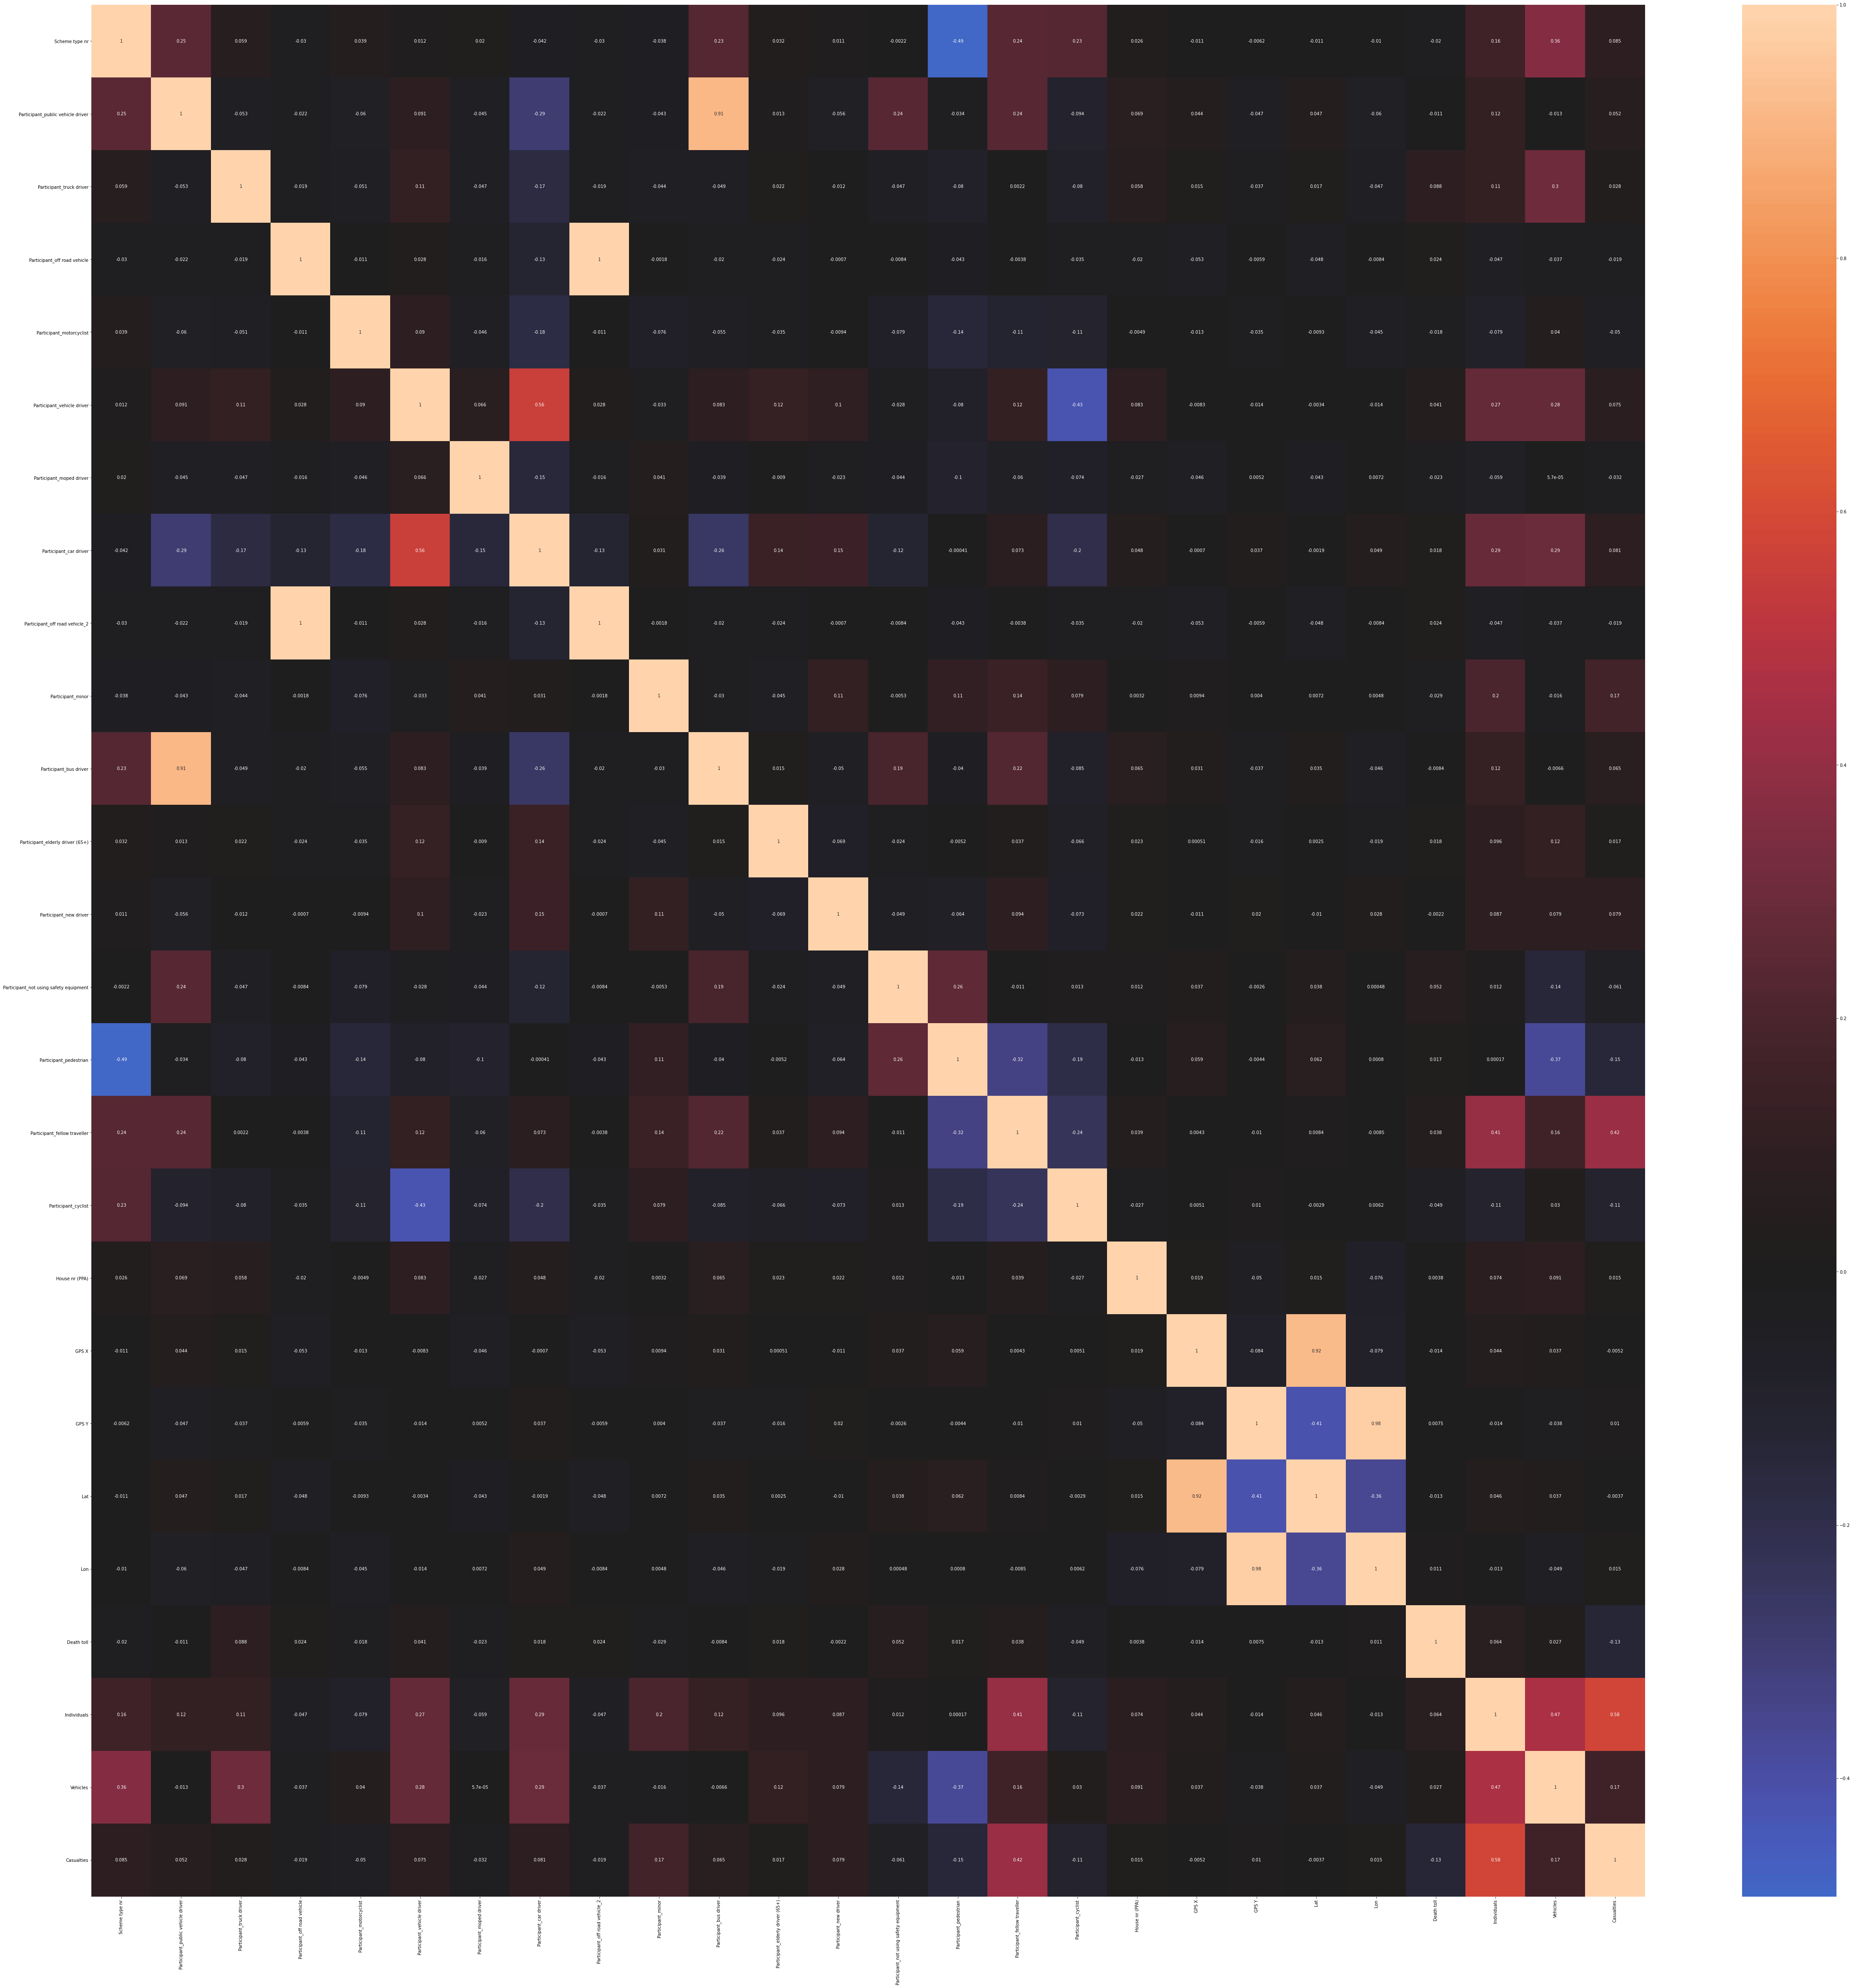

In [5]:
#heatmap to see how features correlate
fig, ax = plt.subplots(figsize=(80,80))
sns.heatmap(data.corr(), center=0, annot=True)
#low corralation -> good

<AxesSubplot:>

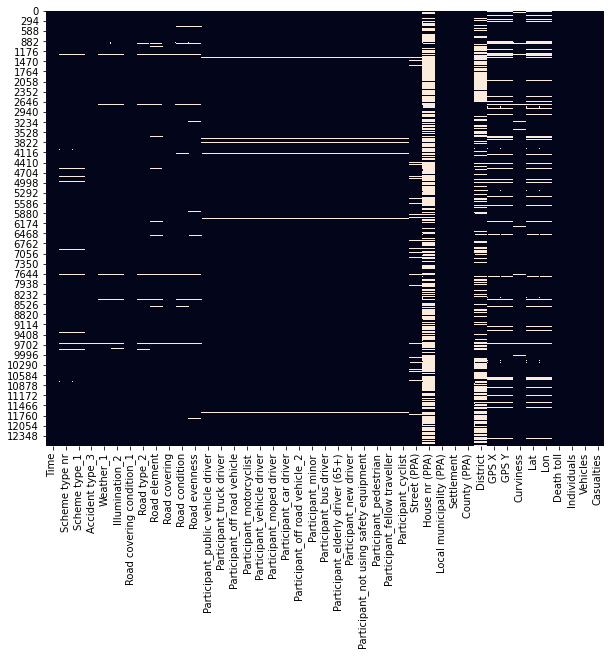

In [6]:
#visualizing nan-values
plt.figure(figsize = (10,8))
sns.heatmap(data.isnull(), cbar=False, xticklabels=1)
#maybe drop house nr and district?

# Goal 1: Find patterns depending on the time of year 

In [7]:
# make some additional features from "Time" feature
data.Time = pd.to_datetime(data.Time)
data['Time_day']=data.Time.dt.dayofweek #monday=0 ... sunday=6
data['Time_dayofmonth']=data.Time.dt.day
data['Time_month']=data.Time.dt.month
data['Time_year']=data.Time.dt.year
data['Time_hour']=data.Time.dt.hour
data

Time  Scheme type nr  \
0     2014-10-24 08:45:00           104.0   
1     2014-10-24 13:45:00           401.0   
2     2014-08-11 15:10:00           207.0   
3     2014-11-17 17:32:00           606.0   
4     2015-04-28 07:55:00           505.0   
...                   ...             ...   
12627 2017-05-21 09:35:00           207.0   
12628 2017-05-21 13:50:00           601.0   
12629 2017-05-22 18:29:00           203.0   
12630 2017-05-22 20:02:00           401.0   
12631 2018-04-16 16:20:00           502.0   

                                         Scheme type_1  \
0                     Vehicle conflict with pedestrian   
1      Vehicles moving to same direction (not passing)   
2                              Single vehicle accident   
3                    Vehicles from opposite directions   
4                    Vehicles from crossing directions   
...                                                ...   
12627                          Single vehicle accident   
12628                Vehicles from opposite directions   
12629                          Single vehicle accident   
12630  Vehicles moving to same direction (not passing)   
12631                Vehicles from crossing directions   

                                Accident type_3        Weather_1  \
0                     Collision with pedestrian            Clear   
1        Collision with vehicle moving in front           Cloudy   
2        Collision with vehicle moving in front           Cloudy   
3               Collision with oncoming vehicle           Cloudy   
4              Collision with vehicle from side         Rainfall   
...                                         ...              ...   
12627  Collision with vehicle standing in front            Clear   
12628           Collision with oncoming vehicle  Sun shining low   
12629                      Vehicle off the road            Clear   
12630    Collision with vehicle moving in front            Clear   
12631          Collision with vehicle from side            Clear   

                Illumination_2 Road covering condition_1        Road type_2  \
0                     Daylight                       Dry             Street   
1                     Daylight                       Dry             Street   
2                     Daylight                       Dry             Street   
3      Night time lighting off                       Dry    Supporting road   
4                     Daylight                       Wet             Street   
...                        ...                       ...                ...   
12627                 Daylight                       Dry  Secondary highway   
12628                 Daylight                       Dry       Main highway   
12629                 Daylight                       Dry       Main highway   
12630                 Daylight                       Dry             Street   
12631                 Daylight                       Dry             Street   

                        Road element       Road covering  ...        Lon  \
0      Road without special features  Permanent pavement  ...  24.751479   
1                  Y-shaped junction  Permanent pavement  ...  24.730850   
2      Road without special features  Permanent pavement  ...  24.840724   
3                  T-shaped junction  Permanent pavement  ...  24.291529   
4                  T-shaped junction  Permanent pavement  ...  24.738815   
...                              ...                 ...  ...        ...   
12627  Road without special features  Permanent pavement  ...  24.340068   
12628                         Bridge  Permanent pavement  ...  24.416737   
12629  Road without special features  Permanent pavement  ...  24.343375   
12630              +-shaped junction  Permanent pavement  ...        NaN   
12631              T-shaped junction  Permanent pavement  ...  25.573435   

      Death toll  Individuals  Vehicles  Casualties  Time_day  \
0              0            2         1

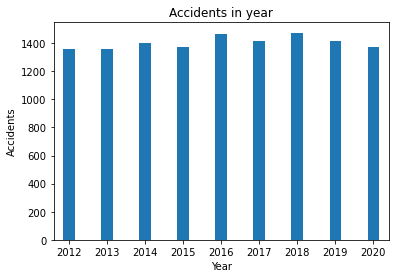

In [8]:
ax = data['Time_year'].value_counts().sort_index().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('Accidents')
ax.set_xlabel('Year')
ax.set_title('Accidents in year');
# number of accident in a year is not changing much and no visiable trendline

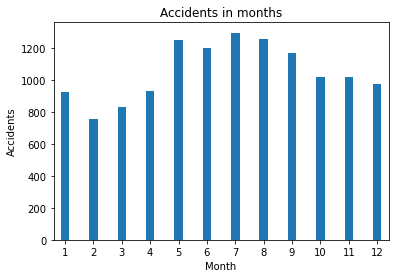

In [9]:
ax = data['Time_month'].value_counts().sort_index().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('Accidents')
ax.set_xlabel('Month')
ax.set_title('Accidents in months');
# most accidents in summer and least in coldest winter months (less driving maybe)

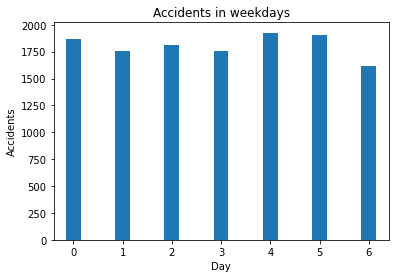

In [10]:
ax = data['Time_day'].value_counts().sort_index().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('Accidents')
ax.set_xlabel('Day')
ax.set_title('Accidents in weekdays');
# seems that sundays has least accidents

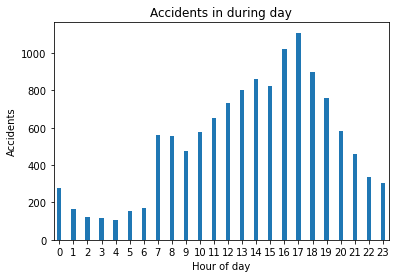

In [11]:
ax = data['Time_hour'].value_counts().sort_index().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('Accidents')
ax.set_xlabel('Hour of day')
ax.set_title('Accidents in during day');

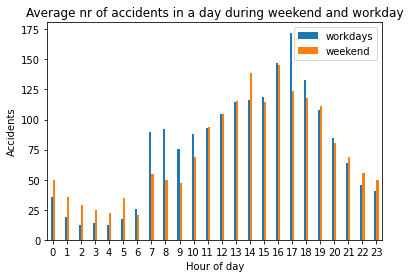

In [12]:
weekdays=data[data['Time_day']<5]['Time_hour'].value_counts().sort_index()/5
weekend=data[data['Time_day']>=5]['Time_hour'].value_counts().sort_index()/2

average=pd.concat([weekdays, weekend], axis=1)
average.columns=['workdays', 'weekend']
ax=average.plot(kind = 'bar',rot = 0, width = 0.3)

ax.set_ylabel('Accidents')
ax.set_xlabel("Hour of day")
ax.set_title('Average nr of accidents in a day during weekend and workday');

# the peak hours are are more or less the same but weekend nights have more accedents than during the workingdays

In [13]:
#counting how many accidents happen in fridays and friday the 13-th
friday=len(data[(data['Time_day']==4) & (data["Time_dayofmonth"]!=13) ])
friday13=len(data[(data['Time_day']==4) & (data["Time_dayofmonth"]==13)])

friday,friday13

(1853, 73)

In [14]:
#counting the number of fridays and friday the 13-th
num_fridays = len(data[(data['Time_day']==4) & (data["Time_dayofmonth"]!=13)][['Time_dayofmonth','Time_month', 'Time_year']].drop_duplicates())
num_friday13s = len(data[(data['Time_day']==4) & (data["Time_dayofmonth"]==13)][['Time_dayofmonth','Time_month', 'Time_year']].drop_duplicates())
num_fridays, num_friday13s

(436, 17)

In [15]:
#average number of accedents on feiday and friday the 13-th
friday/num_fridays, friday13/num_friday13s

(4.25, 4.294117647058823)

In [16]:
# testing if the number of accedents on friday the 13 is higher 
friday=(data[(data['Time_day']==4) & (data["Time_dayofmonth"]!=13) ]).value_counts(['Time_dayofmonth','Time_month', 'Time_year'])
friday13=(data[(data['Time_day']==4) & (data["Time_dayofmonth"]==13)]).value_counts(['Time_dayofmonth','Time_month', 'Time_year'])
friday.values

from scipy import stats
print(stats.shapiro(friday.values)) # test for the normality of distibution
print(stats.shapiro(friday13.values))

stats.ttest_ind(friday.values, friday13.values, equal_var = False)

ShapiroResult(statistic=0.935391902923584, pvalue=8.268785504396414e-13)
ShapiroResult(statistic=0.9276058077812195, pvalue=0.19842995703220367)


Ttest_indResult(statistic=-0.08770321635027999, pvalue=0.9310999880271478)

Since the pvalue is higher than .05, we can not reject the null hypothesis and have to conclude that there is not a statistically significant difference on the number of accidents on friday and friday the 13-th. In terms of number of accidents the friday the 13 is not unhappy day

In [17]:
#counting how many accidents happen in midsummerdays and other days
MSD=len(data[(data['Time_month']==6) & (data["Time_dayofmonth"]==23) ])
Other=len(data[~(data['Time_month']==6) & (data["Time_dayofmonth"]==23)])


#counting the number of accedents on midsummerdays and other days
num_MSD = len(data[(data['Time_month']==6) & (data["Time_dayofmonth"]==23)][['Time_dayofmonth','Time_month', 'Time_year']].drop_duplicates())
num_other= len(data[~(data['Time_month']==6) & (data["Time_dayofmonth"]==23)][['Time_dayofmonth','Time_month', 'Time_year']].drop_duplicates())
num_MSD, num_other

#average number of accedents on midsummerdays and other days
MSD/num_MSD, Other/num_other

(5.111111111111111, 3.8247422680412373)

In [18]:
# testing if the number of accedents on midsummerdays and other days
MSD=(data[(data['Time_month']==6) & (data["Time_dayofmonth"]==23) ]).value_counts(['Time_dayofmonth','Time_month', 'Time_year'])
Other=(data[~(data['Time_month']==6) & (data["Time_dayofmonth"]==23)]).value_counts(['Time_dayofmonth','Time_month', 'Time_year'])


from scipy import stats
print(stats.shapiro(MSD.values)) # test for the normality of distibution
print(stats.shapiro(Other.values))

stats.ttest_ind(MSD.values, Other.values, equal_var = False)

ShapiroResult(statistic=0.826120138168335, pvalue=0.04039105772972107)
ShapiroResult(statistic=0.924606204032898, pvalue=3.256885247537866e-05)


Ttest_indResult(statistic=1.6418324955871573, pvalue=0.13380311083749863)

Although the average number of accidents were rather different the pvalue is still higher than .05, we can not reject the null hypothesis and have to conclude that there is not a statistically significant difference on the number of accidents on midsummer days and other days.

Time_dayofmonth  Time_month  Time_year
15               6           2013         16
14               9           2013         15
21               8           2015         14
8                10          2020         13
6                2           2018         13
                                          ..
10               11          2017          1
24               12          2017          1
                             2013          1
                 11          2020          1
10               4           2017          1
Length: 3150, dtype: int64

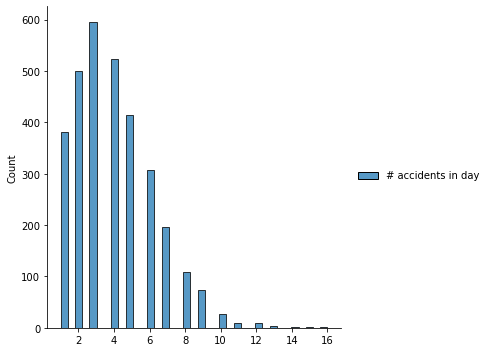

In [19]:
summa=data.value_counts(['Time_dayofmonth','Time_month', 'Time_year'])
display(summa)
sns.displot(summa.to_frame('# accidents in day'))
# finding on what days have the accidents where total number of accidentends (last column) and visualizing the distribution of daily accident numbers

In [20]:
day_stats = data.groupby(['Time_year','Time_month', 'Time_dayofmonth' ]).agg({'Death toll' : ['sum', 'count'], 'Individuals' : ['sum'], 'Vehicles' : ['sum']})
day_stats

Death toll       Individuals Vehicles
                                            sum count         sum      sum
Time_year Time_month Time_dayofmonth                                      
2012      1          1                        0     3           4        3
                     2                        0     3           8        6
                     3                        0     1           2        2
                     4                        0     2           3        2
                     5                        0     7          12        9
...                                         ...   ...         ...      ...
2020      12         25                       0     8          17        9
                     26                       0     4           7        5
                     28                       2     7          14       12
                     30                       0     4           9        6
                     31                       0     3           7        4

[3150 rows x 4 columns]

In [21]:
day_stats.reset_index().sort_values(('Death toll','count'), ascending=False).head(10) #days when most accidents happen (in count column)

Time_year Time_month Time_dayofmonth Death toll       Individuals  \
                                                 sum count         sum   
511       2013          6              15          1    16          18   
599       2013          9              14          5    15          30   
1281      2015          8              21          0    14          24   
2142      2018          2               6          3    13          34   
3071      2020         10               8          0    13          20   
2945      2020          5              30          0    13          23   
2405      2018         11               8          0    12          29   
308       2012         11              12          0    12          24   
1448      2016          2              11          1    12          26   
955       2014          9              19          0    12          21   

     Vehicles  
          sum  
511        16  
599        25  
1281       20  
2142       20  
3071       20  
2945       19  
2405       19  
308        18  
1448       22  
955        17

# Goal 2: Find out what are the main causes for accidents.

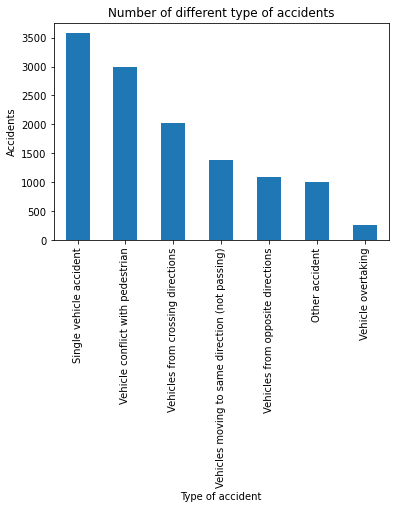

In [22]:
ax=data.value_counts('Scheme type_1').plot(kind="bar")
ax.set_ylabel('Accidents')
ax.set_xlabel('Type of accident')
ax.set_title('Number of different type of accidents');

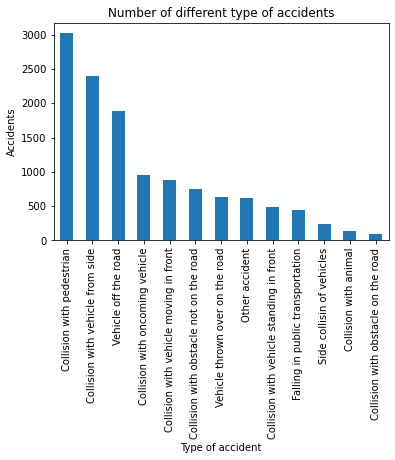

In [23]:
ax=data.value_counts('Accident type_3').plot(kind="bar")
ax.set_ylabel('Accidents')
ax.set_xlabel('Type of accident')
ax.set_title('Number of different type of accidents');

Text(0.5, 0, 'Weather conditions')

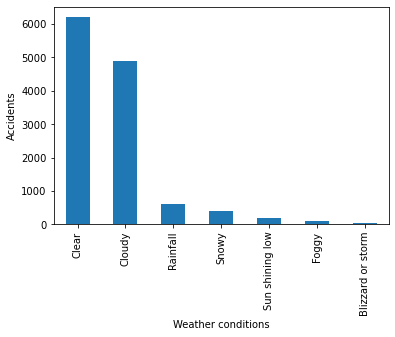

In [24]:
ax=data.value_counts('Weather_1').plot(kind="bar")
ax.set_ylabel('Accidents')
ax.set_xlabel('Weather conditions')

Text(0.5, 0, 'Light conditions')

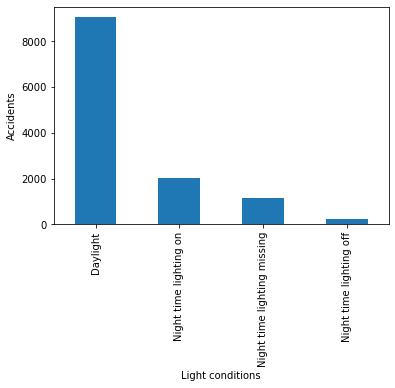

In [25]:
ax=data.value_counts('Illumination_2').plot(kind="bar")
ax.set_ylabel('Accidents')
ax.set_xlabel('Light conditions')


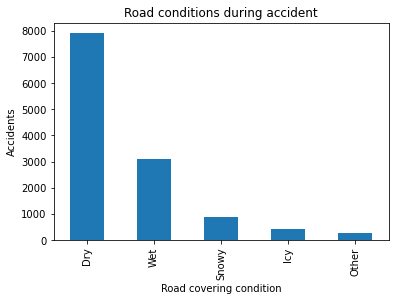

In [26]:
ax=data.value_counts('Road covering condition_1').plot(kind="bar")
ax.set_ylabel('Accidents')
ax.set_xlabel('Road covering condition')
ax.set_title('Road conditions during accident');

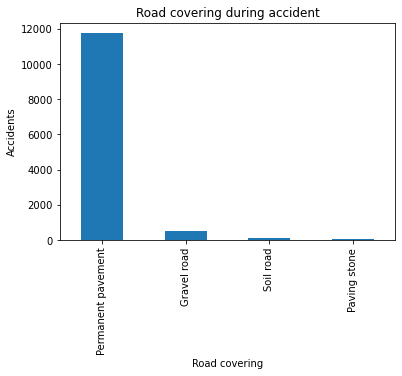

In [27]:
ax=data.value_counts('Road covering').plot(kind="bar")
ax.set_ylabel('Accidents')
ax.set_xlabel('Road covering')
ax.set_title('Road covering during accident');

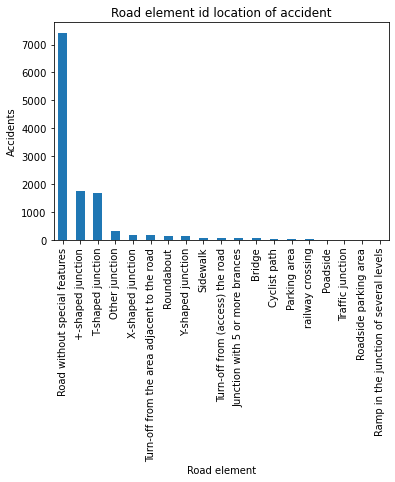

In [28]:
ax=data.value_counts('Road element').plot(kind="bar")
ax.set_ylabel('Accidents')
ax.set_xlabel('Road element')
ax.set_title('Road element id location of accident');

By creating Association Rules of the Features displayed above, we can find out which kind of Combinations of the Featrues cause the most Accidents.

In [29]:
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

data_apriori = pd.DataFrame(columns= {'Scheme type_1','Road element','Road covering','Road covering condition_1','Weather_1','Accident type_3','Weather_1'})
data_apriori['Scheme type_1'] = data['Scheme type_1']
data_apriori['Road element'] = data['Road element']
data_apriori['Road covering'] = data['Road covering']
data_apriori['Road covering condition_1'] = data['Road covering condition_1']
data_apriori['Weather_1'] = data['Weather_1']
data_apriori['Accident type_3'] = data['Accident type_3']
data_apriori['Weather_1'] = data['Weather_1']


# MR: commented out non-working code
#te = TransactionEncoder()
#te_ary = te.fit(data_apriori).transform(data_apriori)
#data_apriori_enc = pd.DataFrame(te_ary, columns=te.columns_)
#
#
#freq_itemsets = apriori(data_apriori_enc, min_support=5/len(data_apriori_enc), use_colnames=True)
#print(freq_itemsets)
#association_rules(freq_itemsets,metric='confidence',min_threshold=0.5)

In [30]:

import apyori

def rules_to_df(rules):
    results = list(rules)
    apriori_df = pd.DataFrame(columns=('Items','Antecedent','Consequent','Support','Confidence','Lift'))

    Support =[]
    Confidence = []
    Lift = []
    Items = []
    Antecedent = []
    Consequent=[]

    for RelationRecord in results:
        for ordered_stat in RelationRecord.ordered_statistics:
            Support.append(RelationRecord.support)
            Items.append(RelationRecord.items)
            Antecedent.append(ordered_stat.items_base)
            Consequent.append(ordered_stat.items_add)
            Confidence.append(ordered_stat.confidence)
            Lift.append(ordered_stat.lift)

    apriori_df['Items'] = list(map(set, Items))                                   
    apriori_df['Antecedent'] = list(map(set, Antecedent))
    apriori_df['Consequent'] = list(map(set, Consequent))
    apriori_df['Support'] = Support
    apriori_df['Confidence'] = Confidence
    apriori_df['Lift']= Lift
    return apriori_df


In [31]:
#data_apriori=data_apriori.values
rules = apyori.apriori(data_apriori.fillna('-').values, min_support = 0.2, min_confidence = 0.5)
rules_df = rules_to_df(rules)
display(rules_df)

Items  \
0                                               {Dry}   
1                                {Permanent pavement}   
2                     {Road without special features}   
3                                        {Dry, Clear}   
4                                        {Dry, Clear}   
5                         {Permanent pavement, Clear}   
6              {Road without special features, Clear}   
7                        {Cloudy, Permanent pavement}   
8             {Cloudy, Road without special features}   
9     {Collision with pedestrian, Permanent pavement}   
10  {Collision with pedestrian, Vehicle conflict w...   
11  {Collision with pedestrian, Vehicle conflict w...   
12                          {Dry, Permanent pavement}   
13                          {Dry, Permanent pavement}   
14                          {Dry, Permanent pavement}   
15               {Dry, Road without special features}   
16               {Dry, Road without special features}   
17  {Road without special features, Permanent pave...   
18  {Road without special features, Permanent pave...   
19  {Road without special features, Permanent pave...   
20      {Permanent pavement, Single vehicle accident}   
21  {Permanent pavement, Vehicle conflict with ped...   
22                          {Wet, Permanent pavement}   
23  {Road without special features, Single vehicle...   
24                   {Dry, Permanent pavement, Clear}   
25                   {Dry, Permanent pavement, Clear}   
26                   {Dry, Permanent pavement, Clear}   
27                   {Dry, Permanent pavement, Clear}   
28                   {Dry, Permanent pavement, Clear}   
29        {Dry, Road without special features, Clear}   
30        {Dry, Road without special features, Clear}   
31        {Dry, Road without special features, Clear}   
32        {Dry, Road without special features, Clear}   
33  {Road without special features, Permanent pave...   
34  {Road without special features, Permanent pave...   
35  {Road without special features, Permanent pave...   
36  {Cloudy, Road without special features, Perman...   
37  {Cloudy, Road without special features, Perman...   
38  {Cloudy, Road without special features, Perman...   
39  {Collision with pedestrian, Permanent pavement...   
40  {Collision with pedestrian, Permanent pavement...   
41  {Collision with pedestrian, Permanent pavement...   
42  {Collision with pedestrian, Permanent pavement...   
43  {Collision with pedestrian, Permanent pavement...   
44  {Dry, Permanent pavement, Road without special...   
45  {Dry, Permanent pavement, Road without special...   
46  {Dry, Permanent pavement, Road without special...   
47  {Dry, Permanent pavement, Road without special...   
48  {Dry, Permanent pavement, Road without special...   
49  {Dry, Permanent pavement, Road without special...   
50  {Dry, Permanent pavement, Road without special...   
51  {Dry, Permanent pavement, Road without special...   
52  {Dry, Permanent pavement, Road without special...   
53  {Dry, Permanent pavement, Road without special...   
54  {Dry, Permanent pavement, Road without special...   
55  {Dry, Permanent pavement, Road without special...   

                                           Antecedent  \
0                                                  {}   
1                                                  {}   
2                                                  {}   
3                                             {Clear}   
4                                               {Dry}   
5                                             {Clear}   
6                                             {Clear}   
7                                            {Cloudy}   
8                                            {Cloudy}   
9                         {Collision with pedestrian}   
10                        {Collision with pedestrian}   
11                 {Vehicle conflict with pedestrian}   
12                                                 {}   


In [32]:
rules_df.sort_values("Support").tail(10)

Items  \
5                         {Permanent pavement, Clear}   
19  {Road without special features, Permanent pave...   
18  {Road without special features, Permanent pave...   
17  {Road without special features, Permanent pave...   
14                          {Dry, Permanent pavement}   
13                          {Dry, Permanent pavement}   
12                          {Dry, Permanent pavement}   
2                     {Road without special features}   
0                                               {Dry}   
1                                {Permanent pavement}   

                         Antecedent  \
5                           {Clear}   
19  {Road without special features}   
18             {Permanent pavement}   
17                               {}   
14             {Permanent pavement}   
13                            {Dry}   
12                               {}   
2                                {}   
0                                {}   
1                                {}   

                                           Consequent   Support  Confidence  \
5                                {Permanent pavement}  0.454877    0.925729   
19                               {Permanent pavement}  0.541482    0.921833   
18                    {Road without special features}  0.541482    0.581188   
17  {Road without special features, Permanent pave...  0.541482    0.541482   
14                                              {Dry}  0.584943    0.627836   
13                               {Permanent pavement}  0.584943    0.934370   
12                          {Dry, Permanent pavement}  0.584943    0.584943   
2                     {Road without special features}  0.587397    0.587397   
0                                               {Dry}  0.626029    0.626029   
1                                {Permanent pavement}  0.931681    0.931681   

        Lift  
5   0.993611  
19  0.989429  
18  0.989429  
17  1.000000  
14  1.002886  
13  1.002886  
12  1.000000  
2   1.000000  
0   1.000000  
1   1.000000

In [33]:
rules_df.sort_values("Lift").tail(10)

Items  \
4                                        {Dry, Clear}   
3                                        {Dry, Clear}   
25                   {Dry, Permanent pavement, Clear}   
27                   {Dry, Permanent pavement, Clear}   
11  {Collision with pedestrian, Vehicle conflict w...   
10  {Collision with pedestrian, Vehicle conflict w...   
43  {Collision with pedestrian, Permanent pavement...   
39  {Collision with pedestrian, Permanent pavement...   
40  {Collision with pedestrian, Permanent pavement...   
41  {Collision with pedestrian, Permanent pavement...   

                                           Antecedent  \
4                                               {Dry}   
3                                             {Clear}   
25                                              {Dry}   
27                        {Permanent pavement, Clear}   
11                 {Vehicle conflict with pedestrian}   
10                        {Collision with pedestrian}   
43  {Permanent pavement, Vehicle conflict with ped...   
39                        {Collision with pedestrian}   
40                 {Vehicle conflict with pedestrian}   
41    {Collision with pedestrian, Permanent pavement}   

                                           Consequent   Support  Confidence  \
4                                             {Clear}  0.424003    0.677289   
3                                               {Dry}  0.424003    0.862897   
25                        {Permanent pavement, Clear}  0.392970    0.627719   
27                                              {Dry}  0.392970    0.863905   
11                        {Collision with pedestrian}  0.228626    0.962667   
10                 {Vehicle conflict with pedestrian}  0.228626    0.956608   
43                        {Collision with pedestrian}  0.220788    0.964051   
39  {Permanent pavement, Vehicle conflict with ped...  0.220788    0.923816   
40    {Collision with pedestrian, Permanent pavement}  0.220788    0.929667   
41                 {Vehicle conflict with pedestrian}  0.220788    0.960730   

        Lift  
4   1.378365  
3   1.378365  
25  1.379976  
27  1.379976  
11  4.027958  
10  4.027958  
43  4.033751  
39  4.033751  
40  4.045315  
41  4.045315

The apriori algorithm was used to find most frequent combinations of road conditions when accidents happen. We used parameters describing road type, conditions and weather conditions ('Scheme type_1','Road element','Road covering','Road covering condition_1','Weather_1','Accident type_3','Weather_1').
The results show that most common combination is normal conditions, typical road and good weather. Nothing special actually.

# Goal 3: Find out what kind of locations have the most accidents.

In [34]:
fig = px.scatter_mapbox(data, lat ="Lat", lon="Lon", size="Casualties", color="Death toll", height=600, zoom=6.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


To illustrate where accidents happen a map was prepared. The dots represent accidents and the size of the dot represents the number of casualties and the color tone number of deaths in an accident.
The accidents are spread all over the country. The area around Tallinn and tartu seems to be denser though. Also major highways can be seen. The big cities can be seen due to the large population and cars. It is also seen that in south Estonia  accidents are also dispersed from major roads and a lot of accidents happen outside major roads. In northern areas the scattering of dots is not so big and more accidents happen on major roads. Also major natural parks and mining areas (Soomaa; Läänemaa, East-Virumaa oils hale mining area combined With Alutaguse etc)  can be seen where less accidents happen (due to less traffic?)

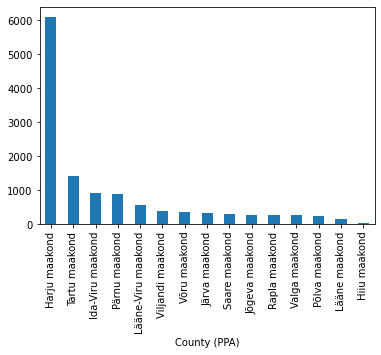

In [35]:
data.value_counts('County (PPA)').plot(kind="bar")
ax.set_ylabel('Accidents')
ax.set_xlabel('County (PPA)')
ax.set_title('Number of accidents in different counties');

Our first guess based on map was right. - most accidents happen in Harjumaa and Tartumaa

Adding the Population Density from Wikipedia to investigate if it is important factor.

In [36]:
county_population = {'Harju maakond':139.83,'Hiiu maakond':9.03,
                     'Ida-Viru maakond':45.17,'Järva maakond':11.28,
                     'Jõgeva maakond':11.18, 'Lääne maakond':11.26,
                     'Lääne-Viru maakond':15.93,'Põlva maakond':13.52,
                     'Pärnu maakond':15.9,'Rapla maakond':12.04,
                     'Saare maakond':11.26,'Tartu maakond':45.78,
                     'Valga maakond':14.71,'Viljandi maakond':13.5,
                     'Võru maakond':12.77}
data = data.assign(col_name='Population Density')
data['Population Density'] = data['County (PPA)']
data['Population Density'] = data['Population Density'].map(county_population)

In [37]:
counts_county = data.value_counts('County (PPA)')
county_population = pd.Series(county_population)
np.corrcoef(counts_county, county_population)

array([[1.        , 0.91602895],
       [0.91602895, 1.        ]])

Our assumption that the amount of accidents and the population density of the country are highly positively correlated -> more accidents happen in areas with higher population

# Goal 4:  Find out what kind of locations have the severest accidents.

In [38]:
deadly_accidents = data[data['Death toll']>0]
fig = px.scatter_mapbox(deadly_accidents, lat ="Lat", lon="Lon", size="Casualties", color="Death toll", height=600, zoom=6.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


To illustrate where severe accidents happen a map was prepared. Accident was considered to be severe when there was one or more people dead. The dots represent accedents  where at least one person was dead and the size of the dot represent number of casualties and the color tone number of deaths in an accient. The accidents are spread all over the country. The area around Tallinn and eastern Estonia cities (Rakvere, Kohtla-Järve) to be denser though. Also major highways can be seen where more severe accidents happen (Tartu-Tallinn and Tallinn-Narva). The big cities can be seen due to large population and cars while in major raods the average speed in probably higher and traffic is denser.


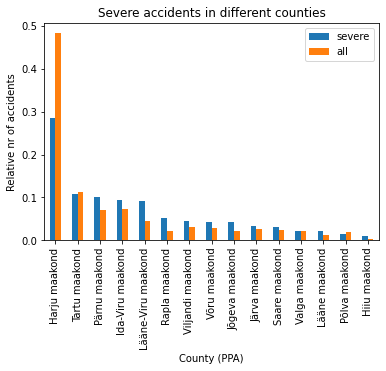

In [39]:
deadly_accidents = data[data['Death toll']>0]

severe_accidents_rel=deadly_accidents.value_counts('County (PPA)') /len(deadly_accidents)
all_accidents_rel=data.value_counts('County (PPA)') /len(data)

average=pd.concat([severe_accidents_rel, all_accidents_rel], axis=1)
average.columns=['severe', 'all']
ax=average.plot(kind = 'bar',rot = 90, width = 0.5)

ax.set_ylabel('Relative nr of accidents')
ax.set_xlabel('County (PPA)')
ax.set_title('Severe accidents in different counties');

In [40]:
print(len(deadly_accidents)/len(data))

counts_county = deadly_accidents.value_counts('County (PPA)')
county_population = pd.Series(county_population)
np.corrcoef(counts_county, county_population)

0.045044331855604816


array([[1.        , 0.83684892],
       [0.83684892, 1.        ]])

Only 4.5% of the accidents are deadly. Deadly accidents are less correlated with the population density than accidents over all.

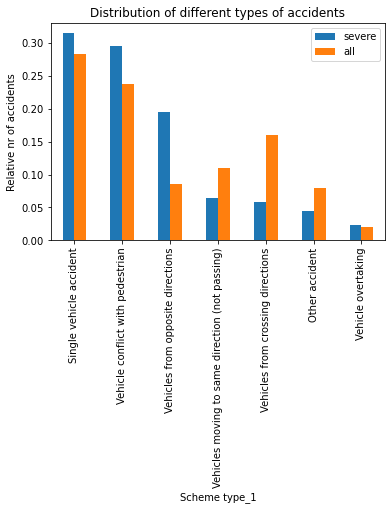

In [41]:
severe_accidents_rel=deadly_accidents.value_counts('Scheme type_1')/len(deadly_accidents)
all_accidents_rel=data.value_counts('Scheme type_1') /len(data)

average=pd.concat([severe_accidents_rel, all_accidents_rel], axis=1)
average.columns=['severe', 'all']
ax=average.plot(kind = 'bar',rot = 90, width = 0.5)

ax.set_ylabel('Relative nr of accidents')
ax.set_xlabel('Scheme type_1')
ax.set_title('Distribution of different types of accidents');

Text(0.5, 1.0, 'Distribution of different types of accidents')

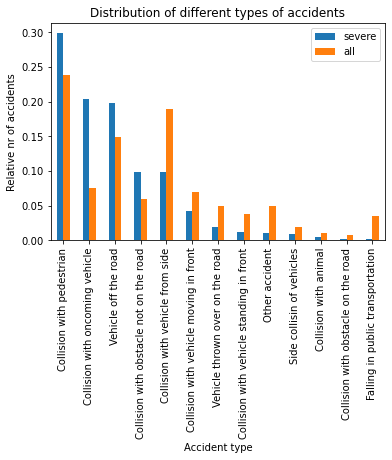

In [42]:
severe_accidents_rel=deadly_accidents.value_counts('Accident type_3') /len(deadly_accidents)
all_accidents_rel=data.value_counts('Accident type_3') /len(data)

average=pd.concat([severe_accidents_rel, all_accidents_rel], axis=1)
average.columns=['severe', 'all']
ax=average.plot(kind = 'bar',rot = 90, width = 0.5)

ax.set_ylabel('Relative nr of accidents')
ax.set_xlabel('Accident type')
ax.set_title('Distribution of different types of accidents')


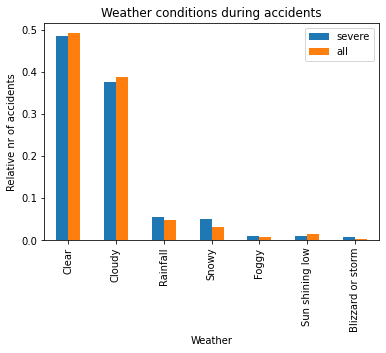

In [43]:
severe_accidents_rel=deadly_accidents.value_counts('Weather_1') /len(deadly_accidents)
all_accidents_rel=data.value_counts('Weather_1') /len(data)

average=pd.concat([severe_accidents_rel, all_accidents_rel], axis=1)
average.columns=['severe', 'all']
ax=average.plot(kind = 'bar',rot = 90, width = 0.5)

ax.set_ylabel('Relative nr of accidents')
ax.set_xlabel('Weather')
ax.set_title('Weather conditions during accidents');

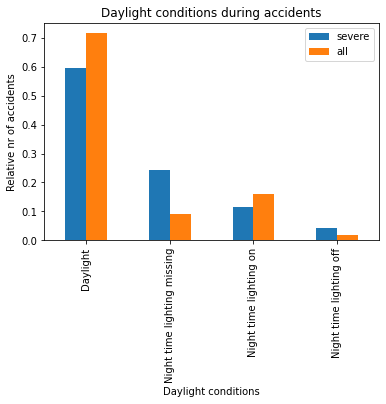

In [44]:
severe_accidents_rel=deadly_accidents.value_counts('Illumination_2') /len(deadly_accidents)
all_accidents_rel=data.value_counts('Illumination_2') /len(data)

average=pd.concat([severe_accidents_rel, all_accidents_rel], axis=1)
average.columns=['severe', 'all']
ax=average.plot(kind = 'bar',rot = 90, width = 0.5)

ax.set_ylabel('Relative nr of accidents')
ax.set_xlabel('Daylight conditions')
ax.set_title("Daylight conditions during accidents");

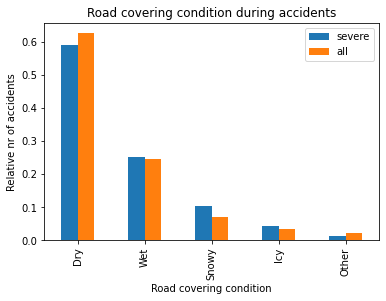

In [45]:
severe_accidents_rel=deadly_accidents.value_counts('Road covering condition_1') /len(deadly_accidents)
all_accidents_rel=data.value_counts('Road covering condition_1') /len(data)

average=pd.concat([severe_accidents_rel, all_accidents_rel], axis=1)
average.columns=['severe', 'all']
ax=average.plot(kind = 'bar',rot = 90, width = 0.5)

ax.set_ylabel('Relative nr of accidents')
ax.set_xlabel('Road covering condition')
ax.set_title('Road covering condition during accidents');

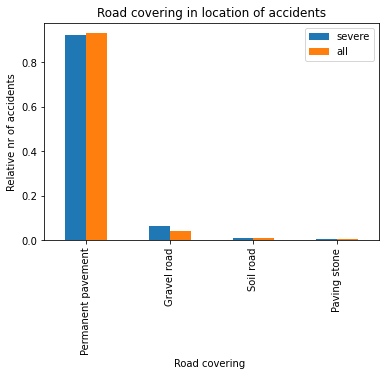

In [46]:
severe_accidents_rel=deadly_accidents.value_counts('Road covering') /len(deadly_accidents)
all_accidents_rel=data.value_counts('Road covering') /len(data)

average=pd.concat([severe_accidents_rel, all_accidents_rel], axis=1)
average.columns=['severe', 'all']
ax=average.plot(kind = 'bar',rot = 90, width = 0.5)

ax.set_ylabel('Relative nr of accidents')
ax.set_xlabel('Road covering ')
ax.set_title('Road covering in location of accidents');

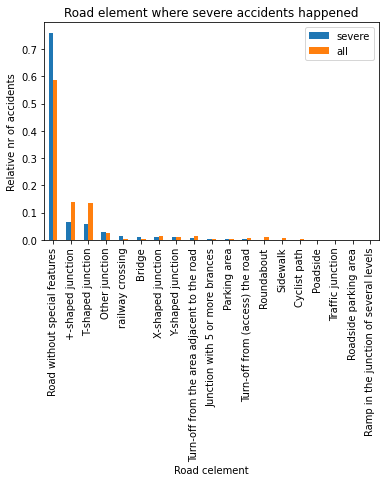

In [47]:
severe_accidents_rel=deadly_accidents.value_counts('Road element') /len(deadly_accidents)
all_accidents_rel=data.value_counts('Road element') /len(data)

average=pd.concat([severe_accidents_rel, all_accidents_rel], axis=1)
average.columns=['severe', 'all']
ax=average.plot(kind = 'bar',rot = 90, width = 0.5)

ax.set_ylabel('Relative nr of accidents')
ax.set_xlabel('Road celement')
ax.set_title('Road element where severe accidents happened');

In [48]:
data2_apriori = pd.DataFrame(columns= {'Scheme type_1','Road element','Road covering','Road covering condition_1','Weather_1','Accident type_3','Weather_1'})
data2_apriori['Scheme type_1'] = deadly_accidents['Scheme type_1']
data2_apriori['Road element'] = deadly_accidents['Road element']
data2_apriori['Road covering'] = deadly_accidents['Road covering']
data2_apriori['Road covering condition_1'] = deadly_accidents['Road covering condition_1']
data2_apriori['Weather_1'] = deadly_accidents['Weather_1']
data2_apriori['Accident type_3'] = deadly_accidents['Accident type_3']
data2_apriori['Weather_1'] = deadly_accidents['Weather_1']


rules = apyori.apriori(data2_apriori.fillna('-').values, min_support = 0.2, min_confidence = 0.5)
rules_df = rules_to_df(rules)
display(rules_df)

Items  \
0                                               {Dry}   
1                                {Permanent pavement}   
2                     {Road without special features}   
3                                        {Dry, Clear}   
4                                        {Dry, Clear}   
..                                                ...   
87  {Collision with pedestrian, Permanent pavement...   
88  {Collision with pedestrian, Permanent pavement...   
89  {Collision with pedestrian, Permanent pavement...   
90  {Collision with pedestrian, Permanent pavement...   
91  {Collision with pedestrian, Permanent pavement...   

                                           Antecedent  \
0                                                  {}   
1                                                  {}   
2                                                  {}   
3                                             {Clear}   
4                                               {Dry}   
..                                                ...   
87  {Road without special features, Vehicle confli...   
88  {Collision with pedestrian, Permanent pavement...   
89  {Collision with pedestrian, Permanent pavement...   
90  {Collision with pedestrian, Road without speci...   
91  {Road without special features, Permanent pave...   

                                         Consequent   Support  Confidence  \
0                                             {Dry}  0.590510    0.590510   
1                              {Permanent pavement}  0.924429    0.924429   
2                   {Road without special features}  0.759227    0.759227   
3                                             {Dry}  0.423550    0.873188   
4                                           {Clear}  0.423550    0.717262   
..                                              ...       ...         ...   
87  {Collision with pedestrian, Permanent pavement}  0.203866    0.958678   
88               {Vehicle conflict with pedestrian}  0.203866    0.983051   
89                  {Road without special features}  0.203866    0.720497   
90                             {Permanent pavement}  0.203866    0.966667   
91                      {Collision with pedestrian}  0.203866    0.991453   

        Lift  
0   1.000000  
1   1.000000  
2   1.000000  
3   1.478703  
4   1.478703  
..       ...  
87  3.346550  
88  3.329500  
89  0.948988  
90  1.045691  
91  3.318451  

[92 rows x 6 columns]

In [49]:
rules_df.sort_values("Support").tail(20)

Items  \
28                   {Dry, Permanent pavement, Clear}   
58  {Dry, Permanent pavement, Road without special...   
57  {Dry, Permanent pavement, Road without special...   
61  {Dry, Permanent pavement, Road without special...   
59  {Dry, Permanent pavement, Road without special...   
60  {Dry, Permanent pavement, Road without special...   
3                                        {Dry, Clear}   
4                                        {Dry, Clear}   
5                         {Permanent pavement, Clear}   
17               {Dry, Road without special features}   
18               {Dry, Road without special features}   
15                          {Dry, Permanent pavement}   
16                          {Dry, Permanent pavement}   
14                          {Dry, Permanent pavement}   
0                                               {Dry}   
22  {Road without special features, Permanent pave...   
20  {Road without special features, Permanent pave...   
21  {Road without special features, Permanent pave...   
2                     {Road without special features}   
1                                {Permanent pavement}   

                                           Antecedent  \
28                                            {Clear}   
58                    {Road without special features}   
57                                              {Dry}   
61  {Road without special features, Permanent pave...   
59                          {Dry, Permanent pavement}   
60               {Dry, Road without special features}   
3                                             {Clear}   
4                                               {Dry}   
5                                             {Clear}   
17                                              {Dry}   
18                    {Road without special features}   
15                                              {Dry}   
16                               {Permanent pavement}   
14                                                 {}   
0                                                  {}   
22                    {Road without special features}   
20                                                 {}   
21                               {Permanent pavement}   
2                                                  {}   
1                                                  {}   

                                           Consequent   Support  Confidence  \
28                          {Dry, Permanent pavement}  0.381371    0.786232   
58                          {Dry, Permanent pavement}  0.400703    0.527778   
57  {Road without special features, Permanent pave...  0.400703    0.678571   
61                                              {Dry}  0.400703    0.572864   
59                    {Road without special features}  0.400703    0.750000   
60                               {Permanent pavement}  0.400703    0.904762   
3                                               {Dry}  0.423550    0.873188   
4                                             {Clear}  0.423550    0.717262   
5                                {Permanent pavement}  0.434095    0.894928   
17                    {Road without special features}  0.442882    0.750000   
18                                              {Dry}  0.442882    0.583333   
15                               {Permanent pavement}  0.534271    0.904762   
16                                              {Dry}  0.534271    0.577947   
14                          {Dry, Permanent pavement}  0.534271    0.534271   
0                                               {Dry}  0.590510    0.590510   
22                               {Permanent pavement}  0.699473    0.921296   
20  {Road without special features, Permanent pave...  0.699473    0.699473   
21                    {Road without special features}  0.699473    0.756654   
2                     {Road without special features}  0.759227    0.759227   
1                                {Permanent pavement}  0.924429    0.924

From apriori it can be seen that most severe accidents happen in normal conditions, good road (permanent cover), nice weather etc. Probably due to unbalance of data - in this area the weather is nice most of the time and most traffic is in major roads which are in good conditions (all can be seen from figures above).

## Goal 5: Find out more useful data 

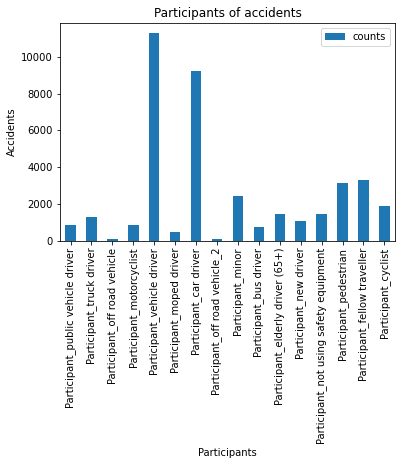

In [50]:
def getSums(dataframe, arguments):
    counts=[]
    for i in range(len(arguments)):
        counts.append(data[data[arguments[i]] == 1.0][arguments[i]].sum())
    return pd.DataFrame({"counts": counts}, index=arguments)
D = getSums(data, ['Participant_public vehicle driver',
       'Participant_truck driver', 'Participant_off road vehicle',
       'Participant_motorcyclist', 'Participant_vehicle driver',
       'Participant_moped driver', 'Participant_car driver',
       'Participant_off road vehicle_2', 'Participant_minor',
       'Participant_bus driver', 'Participant_elderly driver (65+)',
       'Participant_new driver', 'Participant_not using safety equipment',
       'Participant_pedestrian', 'Participant_fellow traveller',
       'Participant_cyclist'])
ax=D.plot(kind="bar")
ax.set_ylabel('Accidents')
ax.set_xlabel('Participants')
ax.set_title('Participants of accidents');

From this graph we can see that there are more minors who participate in accidents then elderly drivers. More accidents occour with cyclists then motorcyclists. It is unclear if there could be less accidents if participants were using safety equipment but it is definately possible.

In [51]:
# look into accidents happened wih pedestrians in Tartu area o see if it possible to find locations where accidents happen more often
# filter out data
data_Tartu = data[(data['Local municipality (PPA)']=="Tartu linn") & (data["Scheme type_1"]=="Vehicle conflict with pedestrian")]
data_Tartu = data_Tartu[~data_Tartu['Lon'].isna()] # DBSCAN requires that NaN values would be removed
data_Tartu

Time  Scheme type nr                     Scheme type_1  \
1764  2015-01-10 13:54:00           106.0  Vehicle conflict with pedestrian   
1807  2012-03-01 16:30:00           109.0  Vehicle conflict with pedestrian   
1809  2012-01-23 16:42:00           104.0  Vehicle conflict with pedestrian   
1811  2012-01-25 08:51:00           104.0  Vehicle conflict with pedestrian   
1813  2012-01-25 17:10:00           198.0  Vehicle conflict with pedestrian   
...                   ...             ...                               ...   
11399 2015-08-10 07:35:00           103.0  Vehicle conflict with pedestrian   
12054 2015-11-02 16:53:00           198.0  Vehicle conflict with pedestrian   
12199 2015-06-09 22:27:00           198.0  Vehicle conflict with pedestrian   
12397 2016-06-21 13:34:00           104.0  Vehicle conflict with pedestrian   
12563 2017-02-23 17:58:00           109.0  Vehicle conflict with pedestrian   

                 Accident type_3 Weather_1               Illumination_2  \
1764   Collision with pedestrian     Clear                     Daylight   
1807   Collision with pedestrian    Cloudy                     Daylight   
1809   Collision with pedestrian    Cloudy       Night time lighting on   
1811   Collision with pedestrian    Cloudy                     Daylight   
1813   Collision with pedestrian    Cloudy       Night time lighting on   
...                          ...       ...                          ...   
11399  Collision with pedestrian    Cloudy                     Daylight   
12054  Collision with pedestrian    Cloudy                     Daylight   
12199  Collision with pedestrian    Cloudy  Night time lighting missing   
12397  Collision with pedestrian     Clear                     Daylight   
12563  Collision with pedestrian    Cloudy       Night time lighting on   

      Road covering condition_1   Road type_2                   Road element  \
1764                        Dry        Street              T-shaped junction   
1807                        Wet        Street              +-shaped junction   
1809                      Snowy        Street  Road without special features   
1811                      Snowy        Street  Road without special features   
1813                      Snowy  Parking area  Road without special features   
...                         ...           ...                            ...   
11399                       Wet        Street  Road without special features   
12054                       Wet        Street  Road without special features   
12199                       Dry        Street  Road without special features   
12397                       Dry        Street  Road without special features   
12563                       Icy        Street              T-shaped junction   

            Road covering  ... Individuals Vehicles  Casualties  Time_day  \
1764   Permanent pavement  ...           2        1           1         5   
1807   Permanent pavement  ...           1        1           1         3   
1809   Permanent pavement  ...           2        1           1         0   
1811   Permanent pavement  ...           2        1           1         2   
1813   Permanent pavement  ...           1        1           1         2   
...                   ...  ...         ...      ...         ...       ...   
11399  Permanent pavement  ...           2        1           1         0   
12054  Permanent pavement  ...           2        1           1         0   
12199         Gravel road  ...           2        1           1         1   
12397  Permanent pavement  ...           2        1           1         1   
12563  Permanent pavement  ...           2        1           1         3   

       Time_dayofmonth  Time_month  Time_year  Time_hour            col_name  \
1764                10           1       2015         13  Population Density   
1807                 1           3       2012         16  Population Density   
1809                23           1       2012

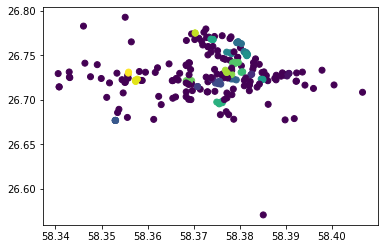

In [52]:
# code adopted from https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data/34579545#34579545
# find clusters

from math import radians, cos, sin, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import pandas as pd


def haversine(lonlat1, lonlat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


X = data_Tartu[['Lat',"Lon"]].copy()
distance_matrix = squareform(pdist(X, (lambda u,v: haversine(u,v))))

db = DBSCAN(eps=0.1, min_samples=3, metric='precomputed')  # using "precomputed" as recommended by @Anony-Mousse
y_db = db.fit_predict(distance_matrix)

X['cluster'] = y_db

plt.scatter(X['Lat'], X['Lon'], c=X['cluster'])
plt.show()

In [53]:
X['cluster'].unique()
# 22 unique clusters = locations where accidens happen frequently

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 21, 11, 16, 12, 13,
       14, 15, 17, 18, 19, 20], dtype=int64)

In [54]:
X['size'] = 1
X.loc[X['cluster']== -1, 'size'] = 0.1
X['Casualties'] = data_Tartu['Casualties']

In [55]:
fig = px.scatter_mapbox(X, lat ="Lat", lon="Lon", size='Casualties', color="cluster", height=600, zoom=12)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update(layout_coloraxis_showscale=False)
fig.show()

To see if it is possible to find locations where accidents happen more often data with Tartu area accidents with pedestrians was used. In map all accidents with pedestrians are marked with dot. Blue ones are accidents which are not grouped - not enough accidents in this area to form a cluster. Other colors are different clusters. When the map is zoomed in then it can be seen that most clusters are near different stores (Selver most often) and places where the traffic is not regulated with traffic lights.